In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_FILE = "/kaggle/input/playground-series-s4e11/train.csv"
TEST_FILE = "/kaggle/input/playground-series-s4e11/test.csv"
SEED = 42

# Data Cleaning and Formatting

In [3]:
df = pd.read_csv(TRAIN_FILE)
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [4]:
# Some column names are too big
df = df.rename(columns={
    "Have you ever had suicidal thoughts ?": "Suicidal Thoughts",
    "Family History of Mental Illness": "Family History",
})

# The Working Professional or Student column is redundant so we'll
# move the "Student" data points to the Profession column
df.loc[df["Working Professional or Student"] == "Student", "Profession"] = "Student"

# Academic Presssure and Study Satisfaction are only available for Students
# We can merge them with Work Pressure and Job Satisfaction
df["Work Pressure"].fillna(df["Academic Pressure"], inplace=True)
df["Job Satisfaction"].fillna(df["Study Satisfaction"], inplace=True)

# Removing the columns we have no use of now
df = df.drop(["id", "Name", "Working Professional or Student", "Academic Pressure", "Study Satisfaction"], axis=1).reset_index(drop=True)

In [5]:
# Let's designate all professions, cities and degrees which have less than 5 samples to "Other"
def reduce_noise(col):
    value_counts = df[col].value_counts()
    rare_values = value_counts[value_counts < 5].index
    df[col] = df[col].replace(rare_values, 'Other')

for col in ["Profession", "City", "Degree"]:
    reduce_noise(col)

In [6]:
# The dataset is kinda unclean, we need to weed out non numerical values from supposedly numerical columns
df['Work/Study Hours'] = pd.to_numeric(df['Work/Study Hours'], errors='coerce')

# Also, convert 2 value columns into true binary columns
df["Family History"] = df["Family History"].map({"Yes": 1, "No": 0})
df["Suicidal Thoughts"] = df["Suicidal Thoughts"].map({"Yes": 1, "No": 0})
df["Gender"] = df["Gender"].map({"Female": 1, "Male": 0})
df['Dietary Habits'] = df['Dietary Habits'].map({
    "Unhealthy": -1,
    "Moderate": 0,
    "Healthy": 1,
})

In [7]:
# Sleep Duration has a bunch of differen values. Also we need to encode the values manually as any
# Encoder will not be able to properly encode these.
print(df["Sleep Duration"].value_counts())

# We map the most common durations, the rest will be converted to nan, 
# which is fine since they are very few in number
df["Sleep Duration"] = df["Sleep Duration"].map({
    "3-4 hours": 4,
    "4-5 hours": 4,
    "Less than 5 hours": 4,
    "5-6 hours": 5,
    "6-7 hours": 6,
    "7-8 hours": 7,
    "More than 8 hours": 8
})

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [8]:
df.sample(10)

,Gender,Age,City,Profession,Work Pressure,CGPA,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Suicidal Thoughts,Work/Study Hours,Financial Stress,Family History,Depression
117902,0,46.0,Delhi,Chef,3.0,NaN,1.0,8.0,-1.0,MHM,1,5.0,5.0,1,0
6985,1,18.0,Kolkata,NaN,3.0,NaN,2.0,8.0,0.0,Class 12,1,9.0,2.0,0,1
20734,1,57.0,Bhopal,Entrepreneur,4.0,NaN,2.0,4.0,1.0,BSc,0,4.0,4.0,0,0
54323,0,42.0,Jaipur,HR Manager,2.0,NaN,2.0,4.0,1.0,M.Tech,0,11.0,4.0,1,0
31778,0,19.0,Thane,Student,3.0,7.48,2.0,8.0,-1.0,Class 12,1,12.0,3.0,0,1
87376,0,57.0,Bhopal,Consultant,4.0,NaN,1.0,8.0,0.0,MBA,0,2.0,1.0,1,0
39788,1,54.0,Jaipur,Entrepreneur,2.0,NaN,2.0,7.0,-1.0,BBA,0,1.0,5.0,0,0
91553,1,27.0,Hyderabad,Software Engineer,3.0,NaN,1.0,7.0,0.0,BCA,0,2.0,1.0,1,0
36493,0,22.0,Faridabad,Pilot,3.0,NaN,5.0,4.0,1.0,B.Tech,1,9.0,5.0,1,1
95509,1,53.0,Nagpur,Teacher,1.0,NaN,1.0,7.0,0.0,M.Ed,1,2.0,4.0,1,0


# Distribution of some of the basic fields
Since the data is a synthetic one, it seems the distribution is intentionally kept very even.

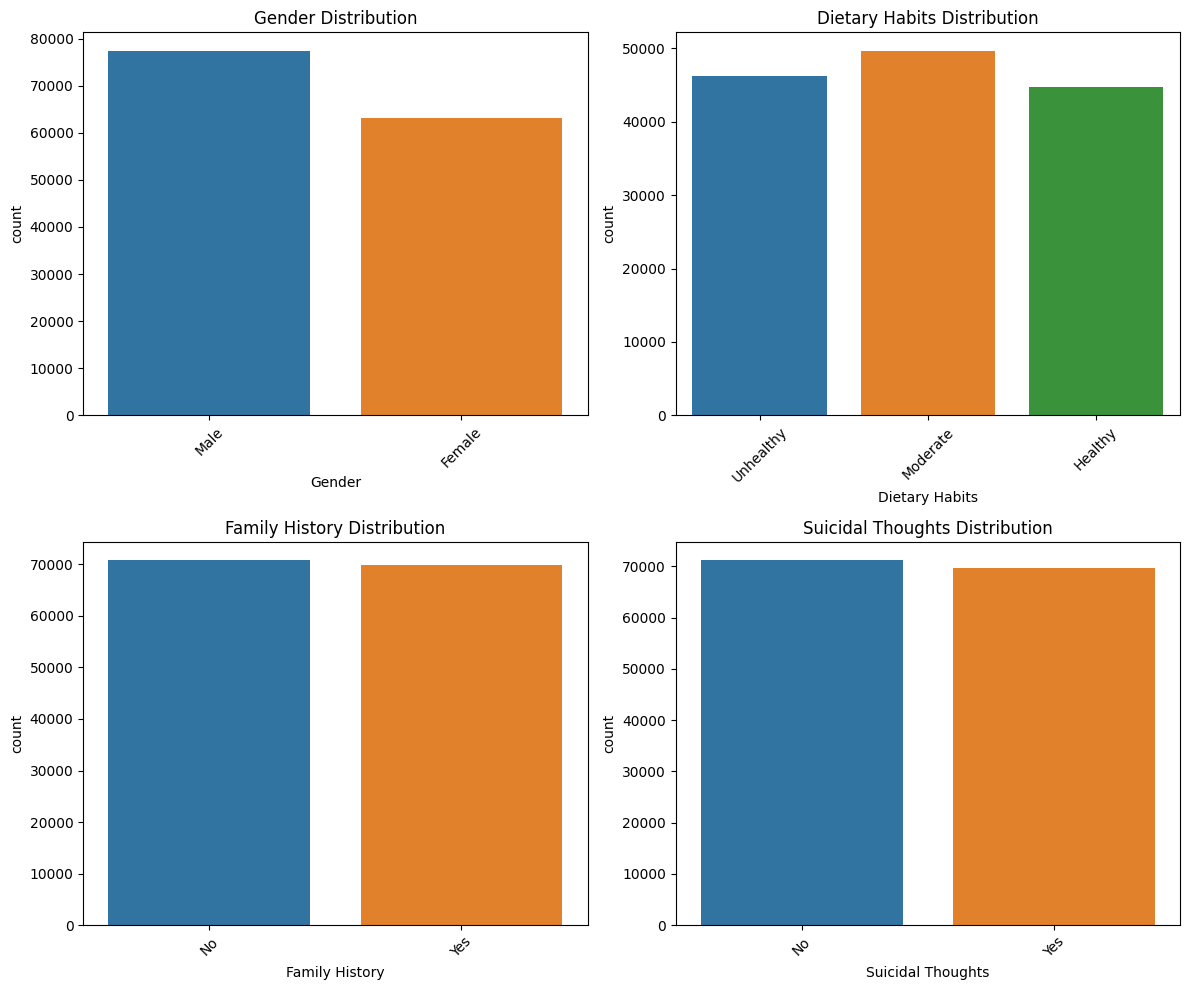

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the columns to plot and the tick labels
categorical_columns = ['Gender', 'Dietary Habits', 'Family History', 'Suicidal Thoughts']
custom_tick_labels = {
    'Gender': ['Male', 'Female'],
    'Dietary Habits': ['Unhealthy', 'Moderate', 'Healthy'],
    'Family History': ['No', 'Yes'],
    'Suicidal Thoughts': ['No', 'Yes']
}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over the columns and corresponding axes
for i, column in enumerate(categorical_columns):
    sns.countplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'{column} Distribution')
    axes[i].set_xticklabels(custom_tick_labels[column], rotation=45)  # Set custom tick labels

# Adjust layout
plt.tight_layout()
plt.show()

### We are going to try out 3 different kinds of models
- Regression Based: Logistic Regression
- Tree Based: XGBoost
- Neural Network Based: TabNet

We'll start by doing some preprocessing to get the data ready and then doing a simple split for now since the data is quite well balanced.

# Preprocessing

In [10]:
numerical_cols = ["Gender", "Age", "Work Pressure", "CGPA", "Job Satisfaction", "Sleep Duration", "Dietary Habits", "Suicidal Thoughts", "Work/Study Hours", "Financial Stress", "Family History"]
categorical_cols = ["City", "Profession", "Degree"]

In [11]:
# Separate features and target variable
X = df.drop(columns=['Depression'])
y = df['Depression']

# Impute missing values in numerical columns with median
num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Impute missing values in categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

In [12]:
# Apply one-hot encoding to categorical features
X = pd.get_dummies(X, columns=categorical_cols, dtype='int', drop_first=True)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=SEED)

# Logistic Regression

In [14]:
def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_loguniform('C', 1e-5, 1e1)  # Regularization strength
    max_iter = trial.suggest_int('max_iter', 5, 100)
    
    # Logistic Regression model with suggested parameters
    model = LogisticRegression(C=C, max_iter=max_iter, random_state=SEED)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_val)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy  # Optuna will maximize this score

In [15]:
# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can increase n_trials for a more thorough search

# Print the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-08 07:14:53,799] A new study created in memory with name: no-name-33317afd-6731-49d5-833b-440392ead1ae
[I 2024-11-08 07:14:55,598] Trial 0 finished with value: 0.935181236673774 and parameters: {'C': 2.9125790469823194, 'max_iter': 43}. Best is trial 0 with value: 0.935181236673774.
[I 2024-11-08 07:14:58,028] Trial 1 finished with value: 0.9354655294953802 and parameters: {'C': 4.438648877376868, 'max_iter': 61}. Best is trial 1 with value: 0.9354655294953802.
[I 2024-11-08 07:14:59,459] Trial 2 finished with value: 0.934044065387349 and parameters: {'C': 0.0021492110239953407, 'max_iter': 34}. Best is trial 1 with value: 0.9354655294953802.
[I 2024-11-08 07:15:00,555] Trial 3 finished with value: 0.9263681592039801 and parameters: {'C': 0.017861211764727984, 'max_iter': 24}. Best is trial 1 with value: 0.9354655294953802.
[I 2024-11-08 07:15:02,706] Trial 4 finished with value: 0.9358919687277896 and parameters: {'C': 0.15407566807386522, 'max_iter': 55}. Best is trial 4 w

Best trial:
  Value: 0.9360341151385928
  Params: 
    C: 0.6108022662567226
    max_iter: 54


In [16]:
# Extract the best parameters
best_params = study.best_params

# Initialize and train the final model with the best parameters
regression_model = LogisticRegression(**best_params, random_state=42)
regression_model.fit(X_train, y_train)

LogisticRegression(C=0.6108022662567226, max_iter=54, random_state=42)

# XGBoost

In [17]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy  # Optuna will maximize this score

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can increase n_trials for more exhaustive search

# Best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-11-08 07:16:47,868] A new study created in memory with name: no-name-04b9806d-524a-4450-b55c-67dd150de87b
[I 2024-11-08 07:16:58,959] Trial 0 finished with value: 0.9375977256574272 and parameters: {'n_estimators': 404, 'max_depth': 4, 'learning_rate': 0.08410275518514786, 'subsample': 0.8763327660071062, 'colsample_bytree': 0.9661967735463154, 'gamma': 3.163302015707008, 'reg_alpha': 0.23538716796047815, 'reg_lambda': 0.0027430673091043967}. Best is trial 0 with value: 0.9375977256574272.
[I 2024-11-08 07:17:14,285] Trial 1 finished with value: 0.9366027007818053 and parameters: {'n_estimators': 281, 'max_depth': 8, 'learning_rate': 0.03226794806059281, 'subsample': 0.8549446701283023, 'colsample_bytree': 0.7081557950185977, 'gamma': 3.940366587892889, 'reg_alpha': 0.00022003760876139494, 'reg_lambda': 0.002119774380003874}. Best is trial 0 with value: 0.9375977256574272.
[I 2024-11-08 07:17:20,295] Trial 2 finished with value: 0.9373134328358209 and parameters: {'n_estimators

Best trial:
  Value: 0.9381663113006397
  Params: 
    n_estimators: 99
    max_depth: 5
    learning_rate: 0.05122092072437093
    subsample: 0.7042415303565083
    colsample_bytree: 0.8800679612750034
    gamma: 1.5067559005349316
    reg_alpha: 0.012841749752291418
    reg_lambda: 0.002089212560383016


In [19]:
# Extract the best parameters
best_params = study.best_params

# Initialize and train the final model with the best parameters
xgb_model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8800679612750034, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=1.5067559005349316, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05122092072437093,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=99, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Neural Network: Pytorch

In [20]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, n_layers, hidden_dim, dropout_rate, activation_fn):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        in_features = input_dim
        
        for _ in range(n_layers):
            layers.append(nn.Linear(in_features, hidden_dim))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'silu':
                layers.append(nn.SiLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_dim

        layers.append(nn.Linear(hidden_dim, 2))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [22]:
def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 1, 4)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation_fn = trial.suggest_categorical("activation_fn", ["relu", "silu"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
    batch_size = trial.suggest_int("batch_size", 128, 2048, step=128)
    n_epochs = 25

    # Define the model
    model = NeuralNetwork(X_train.shape[1], n_layers, hidden_dim, dropout_rate, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Train the model
    model.train()
    for epoch in range(n_epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_tensor)
        _, predicted = torch.max(y_pred, 1)
        accuracy = accuracy_score(y_val_tensor, predicted)
    
    return accuracy

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-08 07:26:33,174] A new study created in memory with name: no-name-f438a88c-939b-4dd7-ba72-0503c460c322
[I 2024-11-08 07:27:36,405] Trial 0 finished with value: 0.9341862117981521 and parameters: {'n_layers': 2, 'hidden_dim': 80, 'dropout_rate': 0.2670810666755411, 'activation_fn': 'relu', 'learning_rate': 0.06715463083978555, 'batch_size': 1792}. Best is trial 0 with value: 0.9341862117981521.
[I 2024-11-08 07:28:40,722] Trial 1 finished with value: 0.9350390902629708 and parameters: {'n_layers': 4, 'hidden_dim': 16, 'dropout_rate': 0.2320906716387553, 'activation_fn': 'silu', 'learning_rate': 0.00944203010622093, 'batch_size': 512}. Best is trial 1 with value: 0.9350390902629708.
[I 2024-11-08 07:29:34,586] Trial 2 finished with value: 0.935181236673774 and parameters: {'n_layers': 1, 'hidden_dim': 32, 'dropout_rate': 0.29927316440336416, 'activation_fn': 'relu', 'learning_rate': 0.00044343193805332105, 'batch_size': 1536}. Best is trial 2 with value: 0.935181236673774.
[I 

Best trial:
  Value: 0.937455579246624
  Params: 
    n_layers: 1
    hidden_dim: 48
    dropout_rate: 0.23489198267756736
    activation_fn: silu
    learning_rate: 0.00424770856363718
    batch_size: 896


# TODO: Prediction
Clean and Process the Test Data and predict